In [1]:
# https://habr.com/ru/company/ods/blog/336168/ (2 часть - как работать с выбросами)

import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, StratifiedKFold
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import ttest_rel

In [2]:
data = pd.read_csv('data/train.csv')
y_train = data['y'].values
X_train = data.drop('y', axis=1).select_dtypes(include=[np.number])
cross_val_score(estimator=xgb.XGBRegressor(objective ='reg:squarederror'),
                X=X_train, y=y_train,
                cv=5, scoring='r2')

# R2 coef - outliers dependant

array([0.37630003, 0.43968909, 0.5886552 , 0.54800137, 0.55752035])

In [3]:
# 1 split into 5 folds --> 10 splits into 5 folds

scores = np.array([])
for i in range(10):
    kf = KFold(n_splits=5, shuffle=True, random_state=i)
    scores_on_this_split = cross_val_score(
        estimator=xgb.XGBRegressor(objective ='reg:squarederror'),
        X=X_train, y=y_train,
        cv=kf, scoring='r2'
    )
    scores = np.append(scores, scores_on_this_split) # 50 scores

1. Compare model results on each fold: score on nth fold ModelA - score on nth fold in ModelB
2. Average differences: (1st fold diff + .. + nth fold diff) / n


Check for significance of scores diffs of 2 models on 50 folds ==> 

t-критерий Стьюдента для связанных выборок:
+ https://www.youtube.com/watch?v=HT3QpRp2ewA&feature=youtu.be)
+ https://www.coursera.org/learn/stats-for-data-analysis/home/welcome
+ https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html

$$T(X_1^n,X_2^n) = \frac{E(X_1)-E(X_2)}{S/\sqrt{n}},$$

где $X_1^n,X_2^n$ списки значений метрики по тестовым фолдам для первой и второй модели соответственно, S – дисперсия попарных разностей, n – число фолдов

H0 - обе модели дают одинаковые результаты

In [4]:
y_train = data['y'].values
X_train = data.drop('y', axis=1).select_dtypes(include=[np.number])
scores_100_trees = np.array([])
scores_110_trees = np.array([])

for i in range(10):
    kf = KFold(n_splits=5, shuffle=True, random_state=i)
    
    # get scores for folds in split with 100 trees
    scores_100_trees_on_this_split = cross_val_score(
        estimator=xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100),
        X=X_train, y=y_train,
        cv=kf, scoring='r2'
    )
    scores_100_trees = np.append(scores_100_trees, scores_100_trees_on_this_split)
    
    # get scores for folds in split with 110 trees
    scores_110_trees_on_this_split = cross_val_score(
        estimator=xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=110),
        X=X_train, y=y_train,
        cv=kf, scoring='r2'
    )
    scores_110_trees = np.append(scores_110_trees, scores_110_trees_on_this_split)
    
ttest_rel(scores_100_trees, scores_110_trees) # 2 ndarrays of r2-scores 

Ttest_relResult(statistic=5.863392177631244, pvalue=3.797169194072895e-07)

In [5]:
# Reject the H0 (models are different)

# сравнение средних
display(pd.DataFrame({
    'mean': [np.mean(scores_100_trees),  np.mean(scores_110_trees)],
    'std': [np.std(scores_100_trees), np.std(scores_110_trees)]
}, index=['100 trees', '110 trees']))

,mean,std
100 trees,0.569014,0.053216
110 trees,0.568195,0.053259


Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 't-statistic')

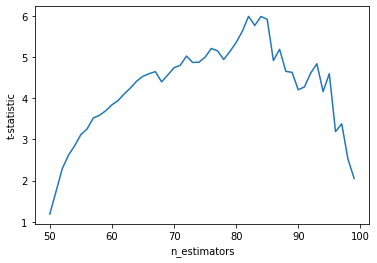

In [6]:
# Altrenatives to GridSearch: optimize important hyperparameters one by one

# Optimize n_estimators
%pylab inline

t_stats = []
n_trees = []
# for each number of estimators
for j in range(50, 100):
    current_score = np.array([])
    # 10 times
    for i in range(10):
        # make 5 splits
        kf = KFold(n_splits=5, shuffle=True, random_state=i)
        # calculate r2 score on each fold as test fold
        scores_on_this_split = cross_val_score(
                                      estimator=xgb.XGBRegressor(objective ='reg:squarederror',
                                                                 n_estimators=j),
                                      X=X_train, y=y_train,
                                      cv=kf, scoring='r2')
        current_score = np.append(current_score,
                                  scores_on_this_split)
        # check significance of diffference with baseline(100 trees)
    t_stat, p_value = ttest_rel(current_score, scores_100_trees)
    t_stats.append(t_stat)
    n_trees.append(j)
plt.plot(n_trees, t_stats)
plt.xlabel('n_estimators')
plt.ylabel('t-statistic')

Отложенная выборка:
1. Посчитали, какой результат дает бейзлайн на отложенной выборке
2. Model hyperparameters tuning 
3. Посчитать результат модели на отложенной выборке


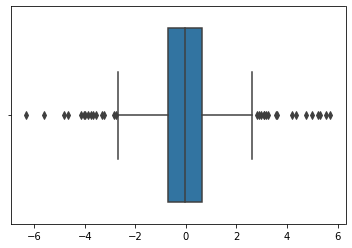

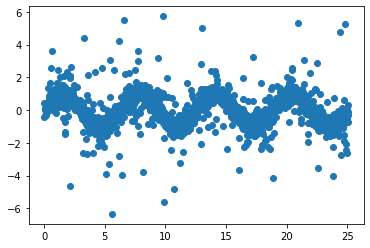

In [7]:
np.random.seed(3)
X = 8 * 3.1415 * np.random.random_sample(size=2000) # (2000,)
y = np.sin(X) + np.random.normal(size=X.size, scale=0.3) # (2000,)
outliers_1 = np.random.randint(low=0, high=X.shape[0], size=int(X.shape[0] * 0.15)) # (300,) [0, 2000]
y[outliers_1] += np.random.normal(size=outliers_1.size, scale=1) # (300,)
outliers_2 = np.random.randint(low=0, high=X.shape[0], size=int(X.shape[0] * 0.04)) # (80,)
y[outliers_2] += np.random.normal(size=outliers_2.size, scale=3)
sns.boxplot(y)
plt.show()
plt.scatter(x=X, y=y)

In [8]:
thr = int(X.shape[0]/2)
X_train = X[:thr].reshape(-1,1)
y_train = y[:thr]
X_test = X[thr:].reshape(-1,1)
y_test = y[thr:]

base_scores_train = np.array([])

# get baseline scores on cv
for i in range(10):
    kf = KFold(n_splits=5, shuffle=True, random_state=i)
    scores_on_this_split = cross_val_score(
        estimator=xgb.XGBRegressor(objective ='reg:squarederror',
                                   min_child_weight=2),
        X=X_train, y=y_train,
        cv=kf, scoring='r2'
    )
    base_scores_train = np.append(base_scores_train, scores_on_this_split)

Text(0, 0.5, 't-statistic')

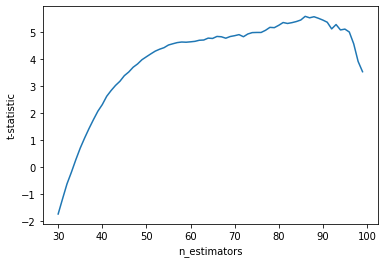

In [9]:
# Compare models (with fewer trees) with baseline

t_stats_train = []

for j in range(30, 100):
    scores_train = np.array([])
    for i in range(10):
        kf = KFold(n_splits=5, shuffle=True, random_state=i)
        scores_on_this_split = cross_val_score(
            estimator=xgb.XGBRegressor(objective ='reg:squarederror',
                                       n_estimators=j,
                                       min_child_weight=2),
            X=X_train, y=y_train,
            cv=kf, scoring='r2')
        
        scores_train = np.append(scores_train, scores_on_this_split)
    t_stat, p_value = ttest_rel(scores_train, base_scores_train)
    t_stats_train.append(t_stat)
plt.plot(range(30, 100), t_stats_train)
plt.xlabel('n_estimators')
plt.ylabel('t-statistic')

# 85 trees - greatest difference

Text(0, 0.5, 'r2_score_test')

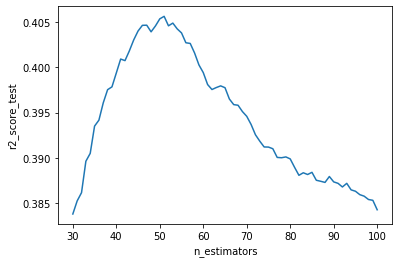

In [10]:
# Check performance on unseen data

scores_test = []
for i in range(30,101):
    est = xgb.XGBRegressor(objective ='reg:squarederror',
                           n_estimators=i,
                           min_child_weight=2)
    est.fit(X_train,y_train)
    scores_test.append(r2_score(y_test, est.predict(X_test)))
plt.plot(range(30, 101), scores_test)
plt.xlabel('n_estimators')
plt.ylabel('r2_score_test')

# 85 trees - not best score (reason - outliers)

In [11]:
# подход:
# Не будем ничего удалять из обучающей выборки, но при валидации (при вычислении
# значения метрики на тестовых фолдах) не будем учитывать выбросы

# определяем выбросы
base_estimator = xgb.XGBRegressor(objective ='reg:squarederror', min_child_weight=2)
# get prediction for each element when it was in test set
pred_train = cross_val_predict(estimator=base_estimator, X=X_train, y=y_train, cv=5)
abs_train_error = np.absolute(y_train - pred_train)
outlier_mask = (abs_train_error > 1.5)
print(f'Outliers fraction in train = {float(y_train[outlier_mask].shape[0]) / y_train.shape[0]}')

# 4.5% outliers

Outliers fraction in train = 0.045


In [12]:
# https://github.com/Danila89/cross_validation_custom/blob/master/cross_val_custom.py

def cross_validation_score_statement(estimator, X, y, scoring, n_splits=5, statement=None, random_state=0):
    """
    Evaluate a score by cross-validation. 
    The fit method will be performed on the entire train subset at each iteration,
    the predict method and scoring will be performed only for objects from test subset where statement is True
    
    Parameters
    ----------
    estimator : estimator object implementing 'fit' and 'predict'
        The object to use to fit the data.
    X : pandas.DataFrame
        The data to fit.
    y : pandas.Series
        The target variable to try to predict.
    scoring : callable 
        The scoring function of signature scoring(y_true, y_pred).
    statement : boolean numpy.array of shape equal to y.shape
        The mask showing the objects we want to evaluate estimator on.
    n_splits : int
        Number of folds for cross-validation
    random_state : int
        Random_state for KFold and StratifiedKFold    
    
    Returns
    -----------
    scores : array of float, shape=(n_splits,)
    
    """
    if statement is None:
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        cv_iter = list(cv.split(X, y)) # indices to split data into train/test
    else:
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        cv_iter = list(cv.split(X, statement))
    scores = []
    
    for train, test in cv_iter:
        estimator.fit(X.iloc[train,:].values, y.iloc[train].values)
        if statement is not None:
            y_statement = y.iloc[test].loc[statement[test]]
            pred_statement = estimator.predict(X.iloc[test,:].loc[statement[test]].values)
        else:
            y_statement = y.iloc[test]
            pred_statement = estimator.predict(X.iloc[test,:].values)
        scores.append(scoring(y_statement,pred_statement))
    return np.array(scores)

Text(0, 0.5, 't-statistic')

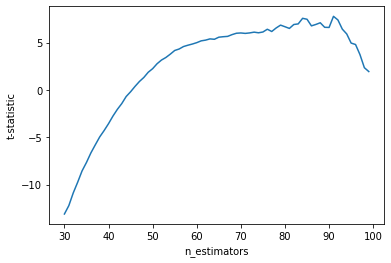

In [13]:
# Calculate scores for baseline (dont consider outliers)
base_scores_train_v2 = np.array([])

for i in range(10):
    scores_on_this_split = cross_validation_score_statement(
        estimator=xgb.XGBRegressor(objective ='reg:squarederror',
                                   min_child_weight=2),
        X=pd.DataFrame(X_train),
        y=pd.Series(y_train),
        scoring=r2_score, n_splits=5,
        random_state=i, 
        statement=~outlier_mask)
    
    base_scores_train_v2 = np.append(base_scores_train_v2, scores_on_this_split)

# Calculate scores for xgb with different n_estimators without outliers
t_stats_train_v2 = []

for j in range(30, 100):
    scores_train_v2 = np.array([])
    for i in range(10):
        fold = KFold(n_splits=5, shuffle=True, random_state=i)
        
        scores_on_this_split = cross_validation_score_statement(
            estimator=xgb.XGBRegressor(objective ='reg:squarederror',
                                       n_estimators=j,
                                       min_child_weight=2),
            X=pd.DataFrame(X_train),
            y=pd.Series(y_train),
            scoring=r2_score, n_splits=5,
            random_state=i, 
            statement=~outlier_mask)
        
        scores_train_v2 = np.append(scores_train_v2, scores_on_this_split)
        
    t_stat, p_value = ttest_rel(scores_train_v2, base_scores_train_v2)
    t_stats_train_v2.append(t_stat)
plt.plot(range(30,100), t_stats_train_v2)
plt.xlabel('n_estimators')
plt.ylabel('t-statistic')